In [1]:
from pathlib import Path

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import keras 
from keras.layers import Dense, Conv2D, BatchNormalization, Activation 
from keras.layers import AveragePooling2D, Input, Flatten 
from keras.optimizers import Adam 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler 
from keras.callbacks import ReduceLROnPlateau 
from keras.preprocessing.image import ImageDataGenerator 
from keras.regularizers import l2 
from keras import backend as K 
from keras.models import Model 

%matplotlib inline

In [11]:
dst = pd.read_csv("C:\Geo-Storm\dst_labels.csv")                          #contains historical data of dst values
dst.timedelta = pd.to_timedelta(dst.timedelta)
dst.set_index(["period", "timedelta"], inplace=True)
sunspots = pd.read_csv("C:\Geo-Storm\sunspots.csv")                       #contains the count of sunspot occurance every month
sunspots.timedelta = pd.to_timedelta(sunspots.timedelta)
sunspots.set_index(["period", "timedelta"], inplace=True)
solar_wind = pd.read_csv("C:\Geo-Storm\solar_wind.csv")                   #contains Parameters of solar wind 
solar_wind.timedelta = pd.to_timedelta(solar_wind.timedelta)
solar_wind.set_index(["period", "timedelta"], inplace=True)

In [12]:
print("Dst shape: ", dst.shape)
dst.head()

Dst shape:  (139872, 1)


dst
period  timedelta           
train_a 0 days 00:00:00   -7
        0 days 01:00:00  -10
        0 days 02:00:00  -10
        0 days 03:00:00   -6
        0 days 04:00:00   -2

In [13]:
dst.groupby("period").describe()

dst                                                    
           count       mean        std    min   25%   50%  75%   max
period                                                              
train_a  28824.0 -16.576707  26.083191 -387.0 -26.0 -12.0 -1.0  65.0
train_b  52584.0  -9.695154  16.443049 -223.0 -17.0  -7.0  1.0  59.0
train_c  58464.0  -9.556325  16.506404 -374.0 -16.0  -7.0  0.0  67.0

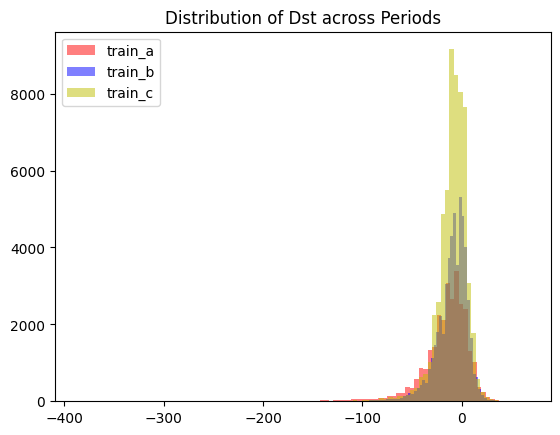

In [14]:
fig, ax = plt.subplots()
colors = ["r", "b", "y"]
for i, period in enumerate(dst.groupby("period")):
    period_name, df = period
    ax.hist(df, alpha=0.5, color=colors[i], bins=100, label=period_name)
plt.legend()
plt.title("Distribution of Dst across Periods")
plt.show()

In [15]:
print("Solar wind shape: ", solar_wind.shape)
solar_wind.head()

Solar wind shape:  (8392320, 15)


bx_gse  by_gse  bz_gse  theta_gse  phi_gse  bx_gsm  \
period  timedelta                                                             
train_a 0 days 00:00:00   -5.55    3.00    1.25      11.09   153.37   -5.55   
        0 days 00:01:00   -5.58    3.16    1.17      10.10   151.91   -5.58   
        0 days 00:02:00   -5.15    3.66    0.85       7.87   146.04   -5.15   
        0 days 00:03:00   -5.20    3.68    0.68       6.17   146.17   -5.20   
        0 days 00:04:00   -5.12    3.68    0.49       4.62   145.72   -5.12   

                         by_gsm  bz_gsm  theta_gsm  phi_gsm    bt  density  \
period  timedelta                                                            
train_a 0 days 00:00:00    3.00    1.25      11.09   153.37  6.80     1.53   
        0 days 00:01:00    3.16    1.17      10.10   151.91  6.83     1.69   
        0 days 00:02:00    3.66    0.85       7.87   146.04  6.77     1.97   
        0 days 00:03:00    3.68    0.68       6.17   146.17  6.74     1.97   
        0 days 00:04:00    3.68    0.49       4.62   145.72  6.65     1.77   

                          speed  temperature source  
period  timedelta                                    
train_a 0 days 00:00:00  383.92     110237.0     ac  
        0 days 00:01:00  381.79     123825.0     ac  
        0 days 00:02:00  389.11      82548.0     ac  
        0 days 00:03:00  389.11      82548.0     ac  
        0 days 00:04:00  384.26      94269.0     ac

In [16]:
print("Sunspot shape: ", sunspots.shape)
sunspots.head()

Sunspot shape:  (192, 1)


smoothed_ssn
period  timedelta              
train_a 0 days             65.4
        13 days            72.0
        44 days            76.9
        74 days            80.8
        105 days           85.4

In [17]:
solar_wind.groupby("period").describe().T

period                  train_a       train_b       train_c
bx_gse      count  1.575012e+06  3.084130e+06  3.407290e+06
            mean  -1.781301e+00 -3.088789e-01 -4.619076e-01
            std    4.339212e+00  3.627830e+00  3.245485e+00
            min   -5.463000e+01 -2.937000e+01 -4.546000e+01
            25%   -4.960000e+00 -3.070000e+00 -2.800000e+00
...                         ...           ...           ...
temperature min    1.000000e+04  1.496000e+03  0.000000e+00
            25%    4.364900e+04  3.741400e+04  4.007400e+04
            50%    7.923800e+04  8.552400e+04  7.152100e+04
            75%    1.325500e+05  1.873250e+05  1.310880e+05
            max    6.223700e+06  4.206672e+06  5.751308e+06

[112 rows x 3 columns]

In [18]:
sunspots.groupby("period").describe().T

period                 train_a     train_b    train_c
smoothed_ssn count   40.000000   72.000000  80.000000
             mean   136.902500   51.850000  24.313750
             std     34.563168   39.200266  19.020414
             min     65.400000    3.900000   2.200000
             25%    108.375000   15.325000   7.775000
             50%    151.500000   43.150000  20.500000
             75%    164.400000   91.225000  38.525000
             max    175.200000  116.400000  69.500000

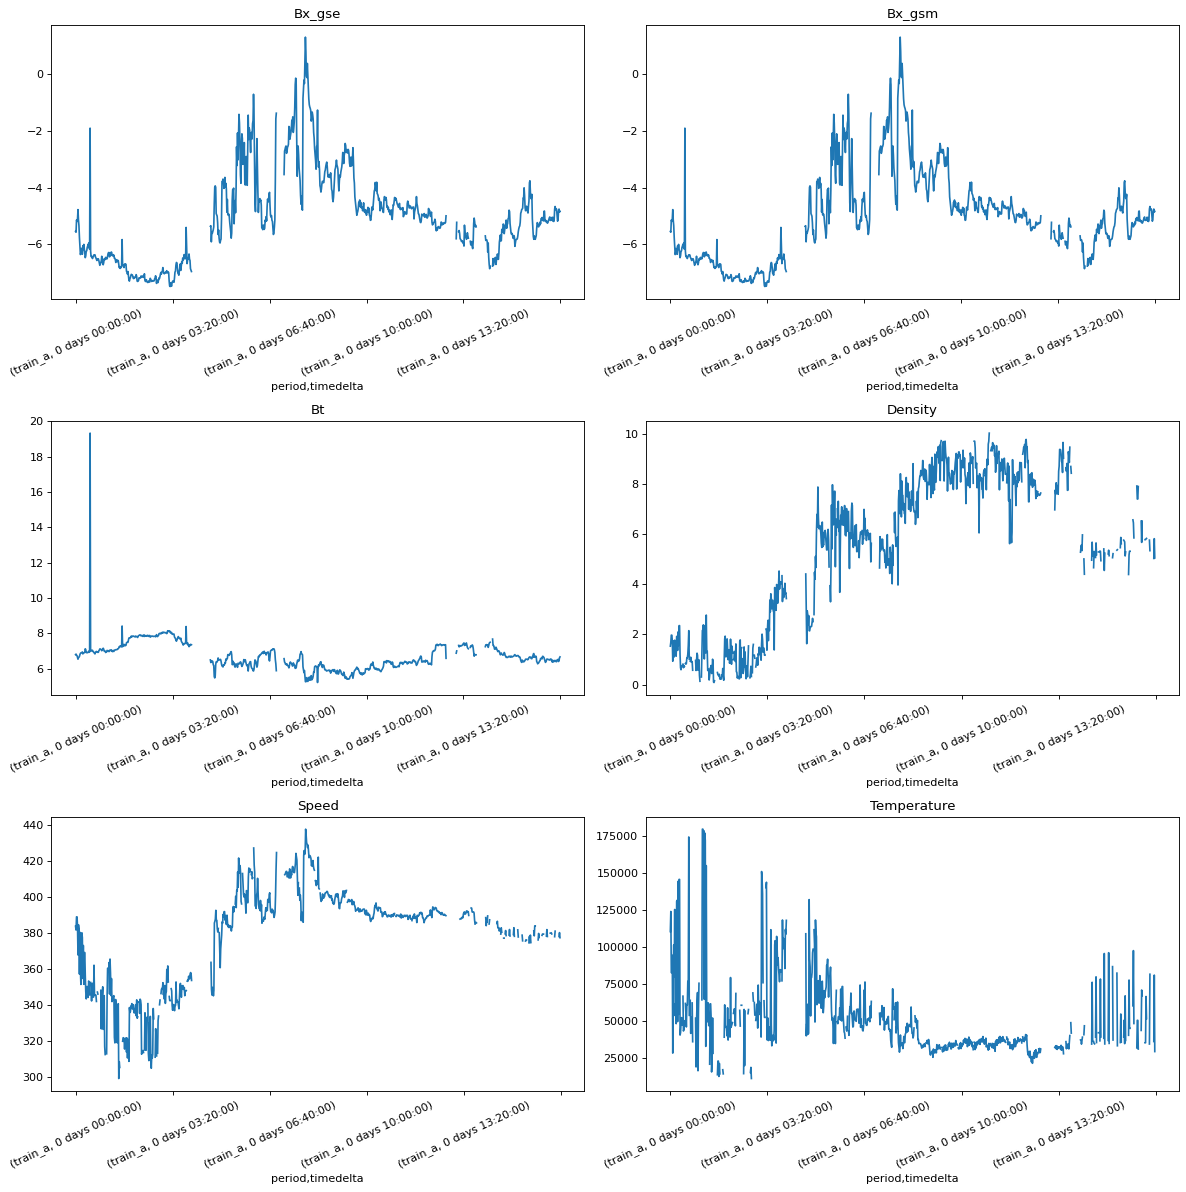

In [19]:
def show_raw_visualization(data):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15), dpi=80)
    for i, key in enumerate(data.columns):
        t_data = data[key]
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            title=f"{key.capitalize()}",
            rot=25,
        )
    fig.subplots_adjust(hspace=0.8)
    plt.tight_layout()
cols_to_plot = ["bx_gse", "bx_gsm", "bt", "density", "speed", "temperature"]
show_raw_visualization(solar_wind[cols_to_plot].iloc[:1000])

In [20]:
solar_wind.isna().sum()

bx_gse         325888
by_gse         325888
bz_gse         325888
theta_gse      325888
phi_gse        326388
bx_gsm         325888
by_gsm         325888
bz_gsm         325888
theta_gsm      325888
phi_gsm        326388
bt             325888
density        684890
speed          689555
temperature    811768
source         316816
dtype: int64

In [30]:
from numpy.random import seed
from tensorflow.random import set_seed
seed(2020)
set_seed(2021)

In [32]:
from sklearn.preprocessing import StandardScaler
SOLAR_WIND_FEATURES = [
    "bt",
    "temperature",
    "bx_gse",
    "by_gse",
    "bz_gse",
    "speed",
    "density",
]

XCOLS = (
    [col + "_mean" for col in SOLAR_WIND_FEATURES]
    + [col + "_std" for col in SOLAR_WIND_FEATURES]
    + ["smoothed_ssn"]
)

def impute_features(feature_df):                                                     #method to impute the missing values using interpolation and forward fill
    feature_df.smoothed_ssn = feature_df.smoothed_ssn.fillna(method="ffill")
    feature_df = feature_df.interpolate()
    return feature_df


def aggregate_hourly(feature_df, aggs=["mean", "std"]):                              #method to aggregate the frequency to standardize 
    agged = feature_df.groupby(["period", feature_df.index.get_level_values(1).floor("H")]).agg(aggs)
    agged.columns = ["_".join(x) for x in agged.columns]
    return agged
    
def preprocess_features(solar_wind, sunspots, scaler=None, subset=None):             #method to standardize the multi-scale parameter into standard one 
    if subset:
        solar_wind = solar_wind[subset]
    hourly_features = aggregate_hourly(solar_wind).join(sunspots)
    if scaler is None:
        scaler = StandardScaler()
        scaler.fit(hourly_features)
    normalized = pd.DataFrame(
        scaler.transform(hourly_features),
        index=hourly_features.index,
        columns=hourly_features.columns,
    )
    imputed = impute_features(normalized)
    return imputed, scaler

In [33]:
features, scaler = preprocess_features(solar_wind, sunspots, subset=SOLAR_WIND_FEATURES)
print(features.shape)
features.head()

C:\Users\tmarj\AppData\Local\Temp\ipykernel_9260\3382149746.py:25: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  agged = feature_df.groupby(["period", feature_df.index.get_level_values(1).floor("H")]).agg(aggs)


(139872, 15)


C:\Users\tmarj\AppData\Local\Temp\ipykernel_9260\3382149746.py:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  feature_df.smoothed_ssn = feature_df.smoothed_ssn.fillna(method="ffill")


bt_mean    bt_std  temperature_mean  \
period  timedelta                                               
train_a 0 days 00:00:00  0.499705  2.443614         -0.375267   
        0 days 01:00:00  0.547177 -0.224580         -0.479430   
        0 days 02:00:00  0.739905 -0.770240         -0.574831   
        0 days 03:00:00  0.699098 -0.278783         -0.324709   
        0 days 04:00:00  0.223933 -0.225168         -0.313432   

                         temperature_std  bx_gse_mean  bx_gse_std  \
period  timedelta                                                   
train_a 0 days 00:00:00         0.383941    -1.599207   -0.381502   
        0 days 01:00:00         0.953178    -1.757995   -0.867747   
        0 days 02:00:00        -0.192518    -1.912116   -1.114317   
        0 days 03:00:00         0.325491    -1.809045   -0.783042   
        0 days 04:00:00         0.201600    -1.338802   -0.484910   

                         by_gse_mean  by_gse_std  bz_gse_mean  bz_gse_std  \
period  timedelta                                                           
train_a 0 days 00:00:00     0.419516    0.031658     0.300358   -0.651645   
        0 days 01:00:00     0.179257   -0.272971     0.446103   -0.517913   
        0 days 02:00:00     0.183266   -0.822786     0.770174   -0.876490   
        0 days 03:00:00    -0.378111    0.341156     0.621194   -0.290211   
        0 days 04:00:00     0.072745    1.023019     0.467629   -0.478080   

                         speed_mean  speed_std  density_mean  density_std  \
period  timedelta                                                           
train_a 0 days 00:00:00   -0.738546   0.862524     -0.775827    -0.205724   
        0 days 01:00:00   -0.986904   0.995063     -0.861692    -0.058215   
        0 days 02:00:00   -1.013548   0.554085     -0.846222    -0.220012   
        0 days 03:00:00   -0.826469  -0.211185     -0.404306     0.218373   
        0 days 04:00:00   -0.601238   1.016033     -0.371487     0.097253   

                         smoothed_ssn  
period  timedelta                      
train_a 0 days 00:00:00      0.139444  
        0 days 01:00:00      0.139444  
        0 days 02:00:00      0.139444  
        0 days 03:00:00      0.139444  
        0 days 04:00:00      0.139444

In [34]:
assert (features.isna().sum() == 0).all() #check to make sure missing values are filled

In [35]:
YCOLS = ["t0", "t1"]
def process_labels(dst):
    y = dst.copy()
    y["t0"] = y.groupby("period").dst.shift(-1)
    y["t1"] = y.groupby("period").dst.shift(-2)
    return y[YCOLS]
labels = process_labels(dst)
labels.head()

t0    t1
period  timedelta                  
train_a 0 days 00:00:00 -10.0 -10.0
        0 days 01:00:00 -10.0  -6.0
        0 days 02:00:00  -6.0  -2.0
        0 days 03:00:00  -2.0   3.0
        0 days 04:00:00   3.0   5.0

In [36]:
data = labels.join(features)
data.head()

t0    t1   bt_mean    bt_std  temperature_mean  \
period  timedelta                                                           
train_a 0 days 00:00:00 -10.0 -10.0  0.499705  2.443614         -0.375267   
        0 days 01:00:00 -10.0  -6.0  0.547177 -0.224580         -0.479430   
        0 days 02:00:00  -6.0  -2.0  0.739905 -0.770240         -0.574831   
        0 days 03:00:00  -2.0   3.0  0.699098 -0.278783         -0.324709   
        0 days 04:00:00   3.0   5.0  0.223933 -0.225168         -0.313432   

                         temperature_std  bx_gse_mean  bx_gse_std  \
period  timedelta                                                   
train_a 0 days 00:00:00         0.383941    -1.599207   -0.381502   
        0 days 01:00:00         0.953178    -1.757995   -0.867747   
        0 days 02:00:00        -0.192518    -1.912116   -1.114317   
        0 days 03:00:00         0.325491    -1.809045   -0.783042   
        0 days 04:00:00         0.201600    -1.338802   -0.484910   

                         by_gse_mean  by_gse_std  bz_gse_mean  bz_gse_std  \
period  timedelta                                                           
train_a 0 days 00:00:00     0.419516    0.031658     0.300358   -0.651645   
        0 days 01:00:00     0.179257   -0.272971     0.446103   -0.517913   
        0 days 02:00:00     0.183266   -0.822786     0.770174   -0.876490   
        0 days 03:00:00    -0.378111    0.341156     0.621194   -0.290211   
        0 days 04:00:00     0.072745    1.023019     0.467629   -0.478080   

                         speed_mean  speed_std  density_mean  density_std  \
period  timedelta                                                           
train_a 0 days 00:00:00   -0.738546   0.862524     -0.775827    -0.205724   
        0 days 01:00:00   -0.986904   0.995063     -0.861692    -0.058215   
        0 days 02:00:00   -1.013548   0.554085     -0.846222    -0.220012   
        0 days 03:00:00   -0.826469  -0.211185     -0.404306     0.218373   
        0 days 04:00:00   -0.601238   1.016033     -0.371487     0.097253   

                         smoothed_ssn  
period  timedelta                      
train_a 0 days 00:00:00      0.139444  
        0 days 01:00:00      0.139444  
        0 days 02:00:00      0.139444  
        0 days 03:00:00      0.139444  
        0 days 04:00:00      0.139444

In [37]:
def get_train_test_val(data, test_per_period, val_per_period):
    test = data.groupby("period").tail(test_per_period)
    interim = data[~data.index.isin(test.index)]
    val = interim.groupby("period").tail(val_per_period)
    train = interim[~interim.index.isin(val.index)]
    return train, test, val
train, test, val = get_train_test_val(data, test_per_period=6_000, val_per_period=3_000)

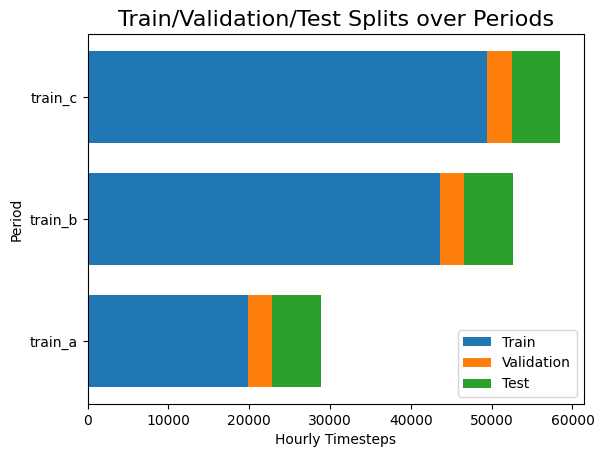

In [38]:
ind = [0, 1, 2]
names = ["train_a", "train_b", "train_c"]
width = 0.75
train_cnts = [len(df) for _, df in train.groupby("period")]
val_cnts = [len(df) for _, df in val.groupby("period")]
test_cnts = [len(df) for _, df in test.groupby("period")]
p1 = plt.barh(ind, train_cnts, width)
p2 = plt.barh(ind, val_cnts, width, left=train_cnts)
p3 = plt.barh(ind, test_cnts, width, left=np.add(val_cnts, train_cnts).tolist())
plt.yticks(ind, names)
plt.ylabel("Period")
plt.xlabel("Hourly Timesteps")
plt.title("Train/Validation/Test Splits over Periods", fontsize=16)
plt.legend(["Train", "Validation", "Test"])

In [39]:
print(train.shape)
train.head()

(112872, 17)


t0    t1   bt_mean    bt_std  temperature_mean  \
period  timedelta                                                           
train_a 0 days 00:00:00 -10.0 -10.0  0.499705  2.443614         -0.375267   
        0 days 01:00:00 -10.0  -6.0  0.547177 -0.224580         -0.479430   
        0 days 02:00:00  -6.0  -2.0  0.739905 -0.770240         -0.574831   
        0 days 03:00:00  -2.0   3.0  0.699098 -0.278783         -0.324709   
        0 days 04:00:00   3.0   5.0  0.223933 -0.225168         -0.313432   

                         temperature_std  bx_gse_mean  bx_gse_std  \
period  timedelta                                                   
train_a 0 days 00:00:00         0.383941    -1.599207   -0.381502   
        0 days 01:00:00         0.953178    -1.757995   -0.867747   
        0 days 02:00:00        -0.192518    -1.912116   -1.114317   
        0 days 03:00:00         0.325491    -1.809045   -0.783042   
        0 days 04:00:00         0.201600    -1.338802   -0.484910   

                         by_gse_mean  by_gse_std  bz_gse_mean  bz_gse_std  \
period  timedelta                                                           
train_a 0 days 00:00:00     0.419516    0.031658     0.300358   -0.651645   
        0 days 01:00:00     0.179257   -0.272971     0.446103   -0.517913   
        0 days 02:00:00     0.183266   -0.822786     0.770174   -0.876490   
        0 days 03:00:00    -0.378111    0.341156     0.621194   -0.290211   
        0 days 04:00:00     0.072745    1.023019     0.467629   -0.478080   

                         speed_mean  speed_std  density_mean  density_std  \
period  timedelta                                                           
train_a 0 days 00:00:00   -0.738546   0.862524     -0.775827    -0.205724   
        0 days 01:00:00   -0.986904   0.995063     -0.861692    -0.058215   
        0 days 02:00:00   -1.013548   0.554085     -0.846222    -0.220012   
        0 days 03:00:00   -0.826469  -0.211185     -0.404306     0.218373   
        0 days 04:00:00   -0.601238   1.016033     -0.371487     0.097253   

                         smoothed_ssn  
period  timedelta                      
train_a 0 days 00:00:00      0.139444  
        0 days 01:00:00      0.139444  
        0 days 02:00:00      0.139444  
        0 days 03:00:00      0.139444  
        0 days 04:00:00      0.139444

In [40]:
print(test.shape)
test.head()

(18000, 17)


t0   t1   bt_mean    bt_std  temperature_mean  \
period  timedelta                                                           
train_a 951 days 00:00:00 -9.0 -9.0 -0.750759  0.234958         -0.321374   
        951 days 01:00:00 -9.0 -6.0 -0.791318  0.284752         -0.319784   
        951 days 02:00:00 -6.0 -7.0 -0.980331  0.573975         -0.257948   
        951 days 03:00:00 -7.0 -7.0 -1.043536 -0.412378         -0.209809   
        951 days 04:00:00 -7.0 -9.0 -0.993770 -0.603035         -0.189010   

                           temperature_std  bx_gse_mean  bx_gse_std  \
period  timedelta                                                     
train_a 951 days 00:00:00        -0.263304     0.437479   -0.443221   
        951 days 01:00:00        -0.301259     0.321370    0.422124   
        951 days 02:00:00        -0.344924     0.530721    0.818555   
        951 days 03:00:00        -0.397676     0.753977   -0.432534   
        951 days 04:00:00        -0.402766     0.789420   -0.391195   

                           by_gse_mean  by_gse_std  bz_gse_mean  bz_gse_std  \
period  timedelta                                                             
train_a 951 days 00:00:00    -0.202748    0.318096     0.849393   -0.020478   
        951 days 01:00:00    -0.240443    0.166232     0.776471   -0.220270   
        951 days 02:00:00    -0.137579    0.157993     0.147218   -0.276363   
        951 days 03:00:00    -0.157578   -0.430909     0.121454   -0.282263   
        951 days 04:00:00    -0.252788   -0.372368    -0.149991   -0.510691   

                           speed_mean  speed_std  density_mean  density_std  \
period  timedelta                                                             
train_a 951 days 00:00:00   -0.145924  -0.503193     -0.407614    -0.315154   
        951 days 01:00:00   -0.127991  -0.084971     -0.427620    -0.198320   
        951 days 02:00:00   -0.120626  -0.310757     -0.435274    -0.374498   
        951 days 03:00:00   -0.180313  -0.531222     -0.414209    -0.365694   
        951 days 04:00:00   -0.219717  -0.649039     -0.437909    -0.267683   

                           smoothed_ssn  
period  timedelta                        
train_a 951 days 00:00:00      2.113449  
        951 days 01:00:00      2.113449  
        951 days 02:00:00      2.113449  
        951 days 03:00:00      2.113449  
        951 days 04:00:00      2.113449

In [41]:
print(val.shape)
val.head()

(9000, 17)


t0   t1   bt_mean    bt_std  temperature_mean  \
period  timedelta                                                           
train_a 826 days 00:00:00  8.0  8.0  0.947600 -0.229038         -0.473006   
        826 days 01:00:00  8.0  9.0  0.464361  0.276422          0.316358   
        826 days 02:00:00  9.0  8.0  0.273709  0.197794          0.073052   
        826 days 03:00:00  8.0  8.0  0.078250  0.445950          0.290167   
        826 days 04:00:00  8.0  8.0 -0.172001  0.071668          0.336941   

                           temperature_std  bx_gse_mean  bx_gse_std  \
period  timedelta                                                     
train_a 826 days 00:00:00        -0.372466    -1.575773   -0.882804   
        826 days 01:00:00         0.379133    -1.614668   -0.280527   
        826 days 02:00:00         0.302776    -1.130185    0.809654   
        826 days 03:00:00         0.460514    -0.943295    1.891776   
        826 days 04:00:00         0.437184    -0.771915    0.408708   

                           by_gse_mean  by_gse_std  bz_gse_mean  bz_gse_std  \
period  timedelta                                                             
train_a 826 days 00:00:00     0.097349    1.132243     1.867509   -0.274071   
        826 days 01:00:00     0.397057    0.655653     0.530847    0.238450   
        826 days 02:00:00     0.320615    0.122597    -1.297872   -0.367564   
        826 days 03:00:00    -0.062777   -0.024515    -0.681155    1.253984   
        826 days 04:00:00     0.332551   -0.049795    -0.704262    1.021870   

                           speed_mean  speed_std  density_mean  density_std  \
period  timedelta                                                             
train_a 826 days 00:00:00   -0.323757  -0.527592      0.392352    -0.296261   
        826 days 01:00:00   -0.155733   0.142157      0.022523    -0.150077   
        826 days 02:00:00   -0.072557   0.563556     -0.200011    -0.089490   
        826 days 03:00:00   -0.001116   0.127350      0.135548     0.048349   
        826 days 04:00:00    0.063829   0.143625     -0.027986    -0.066235   

                           smoothed_ssn  
period  timedelta                        
train_a 826 days 00:00:00      2.191722  
        826 days 01:00:00      2.191722  
        826 days 02:00:00      2.191722  
        826 days 03:00:00      2.191722  
        826 days 04:00:00      2.191722